In [1]:
import pandas as pd
import numpy as np

# Sample case IDs
case_ids = [f'case_{i+1}' for i in range(15)]

# Attributes
attributes = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']

# Generate ground truth (binary)
np.random.seed(42)
ground_truth_data = {'case_id': case_ids}
for attr in attributes:
    ground_truth_data[attr] = np.random.choice([0,1], size=15, p=[0.7,0.3])
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.to_csv('ground_truth.csv', index=False)

# Generate probabilistic model outputs with noise
def generate_model_output_probs(gt_df, noise_level=0.1, model_name='model'):
    np.random.seed(hash(model_name) % 2**32)
    model_data = {'case_id': gt_df['case_id']}
    for attr in attributes:
        probs = gt_df[attr] * (1 - noise_level) + (1 - gt_df[attr]) * noise_level
        probs = probs + np.random.normal(0, noise_level/2, size=len(probs))
        probs = np.clip(probs, 0, 1)
        model_data[attr] = probs
    return pd.DataFrame(model_data)

model_1_df = generate_model_output_probs(ground_truth_df, noise_level=0.5, model_name='Model_1')
model_2_df = generate_model_output_probs(ground_truth_df, noise_level=0.6, model_name='Model_2')
model_3_df = generate_model_output_probs(ground_truth_df, noise_level=0.7, model_name='Model_3')

model_1_df.to_csv('model_output_1.csv', index=False)
model_2_df.to_csv('model_output_2.csv', index=False)
model_3_df.to_csv('model_output_3.csv', index=False)


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Load data
gt_df = pd.read_csv('ground_truth.csv')
model_outputs = {
    'Model_1': pd.read_csv('model_output_1.csv'),
    'Model_2': pd.read_csv('model_output_2.csv'),
    'Model_3': pd.read_csv('model_output_3.csv'),
}

attributes = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']

def compute_metrics_at_threshold(gt, probs, threshold, attribute):
    y_true = gt[attribute]
    y_pred = (probs[attribute] >= threshold).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

def plot_pr_curve(gt, probs, attribute, model_name):
    y_true = gt[attribute]
    y_scores = probs[attribute]
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f'{model_name} (AP={ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {attribute}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves_all_models(gt, model_outputs, attribute):
    plt.figure(figsize=(8,6))

    for model_name, probs in model_outputs.items():
        y_true = gt[attribute]
        y_scores = probs[attribute]

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)

        plt.plot(recall, precision, label=f'{model_name} (AP={ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for "{attribute}"')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


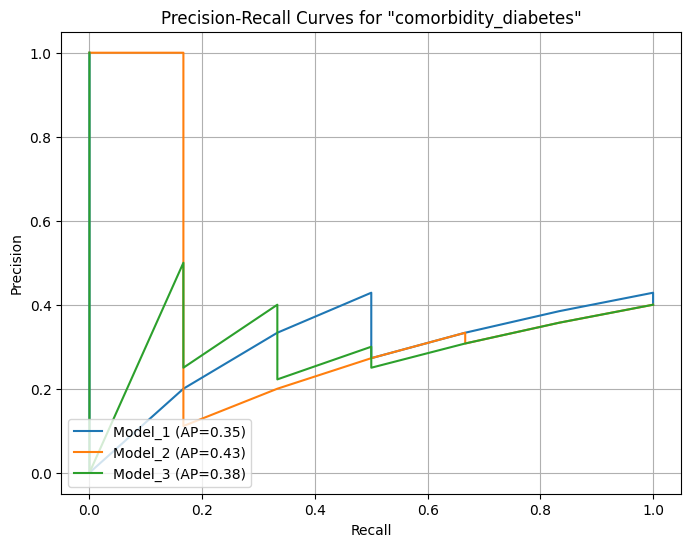

In [4]:
plot_pr_curves_all_models(gt_df, model_outputs, 'comorbidity_diabetes')

In [5]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score

def summarize_metrics(gt, model_outputs, threshold):
    attributes = [col for col in gt.columns if col != 'case_id']
    rows = []

    for model_name, probs in model_outputs.items():
        for attr in attributes:
            y_true = gt[attr]
            y_scores = probs[attr]
            y_pred = (y_scores >= threshold).astype(int)

            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred)
            avg_prec = average_precision_score(y_true, y_scores)

            rows.append({
                'Model': model_name,
                'Attribute': attr,
                'Threshold': threshold,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Accuracy': accuracy,
                'Average Precision (AP)': avg_prec
            })

    summary_df = pd.DataFrame(rows)
    return summary_df

# Example usage:
threshold = 0.5
summary = summarize_metrics(ground_truth_df, model_outputs, threshold)
print(summary)


      Model                 Attribute  Threshold  Precision    Recall  \
0   Model_1      comorbidity_diabetes        0.5   0.428571  0.500000   
1   Model_1  comorbidity_hypertension        0.5   0.142857  1.000000   
2   Model_1        medication_aspirin        0.5   0.300000  0.750000   
3   Model_1          mortality_30_day        0.5   0.333333  0.200000   
4   Model_2      comorbidity_diabetes        0.5   0.111111  0.166667   
5   Model_2  comorbidity_hypertension        0.5   0.000000  0.000000   
6   Model_2        medication_aspirin        0.5   0.111111  0.250000   
7   Model_2          mortality_30_day        0.5   0.300000  0.600000   
8   Model_3      comorbidity_diabetes        0.5   0.333333  0.333333   
9   Model_3  comorbidity_hypertension        0.5   0.000000  0.000000   
10  Model_3        medication_aspirin        0.5   0.181818  0.500000   
11  Model_3          mortality_30_day        0.5   0.166667  0.200000   

          F1  Accuracy  Average Precision (AP)  
0

In [6]:
def styled_metrics_by_model(summary_df):
    def color_rows_by_model(row):
        # Assign a color based on model name hash (consistent but different per model)
        colors = ['#E3F2FD', '#FFF3E0', '#E8F5E9', '#F3E5F5', '#FFEBEE']
        model_list = summary_df['Model'].unique()
        color_map = {model: colors[i % len(colors)] for i, model in enumerate(model_list)}
        return [f'background-color: {color_map[row["Model"]]}'] * len(row)

    styled = summary_df.style.apply(color_rows_by_model, axis=1) \
                              .background_gradient(subset=['Precision', 'Recall', 'F1', 'Accuracy', 'Average Precision (AP)'], cmap='RdYlGn', vmin=0, vmax=1) \
                              .format(precision=2) \
                              .set_properties(**{'text-align': 'center'}) \
                              .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    display(styled)


In [7]:
styled_metrics_by_model(summary)

,Model,Attribute,Threshold,Precision,Recall,F1,Accuracy,Average Precision (AP)
0,Model_1,comorbidity_diabetes,0.50,0.43,0.50,0.46,0.53,0.35
1,Model_1,comorbidity_hypertension,0.50,0.14,1.00,0.25,0.60,0.20
2,Model_1,medication_aspirin,0.50,0.30,0.75,0.43,0.47,0.57
3,Model_1,mortality_30_day,0.50,0.33,0.20,0.25,0.60,0.48
4,Model_2,comorbidity_diabetes,0.50,0.11,0.17,0.13,0.13,0.43
5,Model_2,comorbidity_hypertension,0.50,0.00,0.00,0.00,0.53,0.11
6,Model_2,medication_aspirin,0.50,0.11,0.25,0.15,0.27,0.20
7,Model_2,mortality_30_day,0.50,0.30,0.60,0.40,0.40,0.33
8,Model_3,comorbidity_diabetes,0.50,0.33,0.33,0.33,0.47,0.38
9,Model_3,comorbidity_hypertension,0.50,0.00,0.00,0.00,0.20,0.07


In [8]:
from sklearn.metrics import cohen_kappa_score

def calculate_cohens_kappa(gt, model_outputs, threshold):
    attributes = [col for col in gt.columns if col != 'case_id']
    rows = []

    for model_name, probs in model_outputs.items():
        for attr in attributes:
            y_true = gt[attr]
            y_scores = probs[attr]
            y_pred = (y_scores >= threshold).astype(int)

            kappa = cohen_kappa_score(y_true, y_pred)

            rows.append({
                'Model': model_name,
                'Attribute': attr,
                'Threshold': threshold,
                'Cohen\'s Kappa': kappa
            })

    kappa_df = pd.DataFrame(rows)
    return kappa_df

# Example usage:
threshold = 0.5
kappa_summary = calculate_cohens_kappa(ground_truth_df, model_outputs, threshold)
print(kappa_summary)


      Model                 Attribute  Threshold  Cohen's Kappa
0   Model_1      comorbidity_diabetes        0.5       0.054054
1   Model_1  comorbidity_hypertension        0.5       0.150943
2   Model_1        medication_aspirin        0.5       0.076923
3   Model_1          mortality_30_day        0.5       0.000000
4   Model_2      comorbidity_diabetes        0.5      -0.666667
5   Model_2  comorbidity_hypertension        0.5      -0.129032
6   Model_2        medication_aspirin        0.5      -0.341463
7   Model_2          mortality_30_day        0.5      -0.080000
8   Model_3      comorbidity_diabetes        0.5      -0.111111
9   Model_3  comorbidity_hypertension        0.5      -0.139241
10  Model_3        medication_aspirin        0.5      -0.204380
11  Model_3          mortality_30_day        0.5      -0.285714


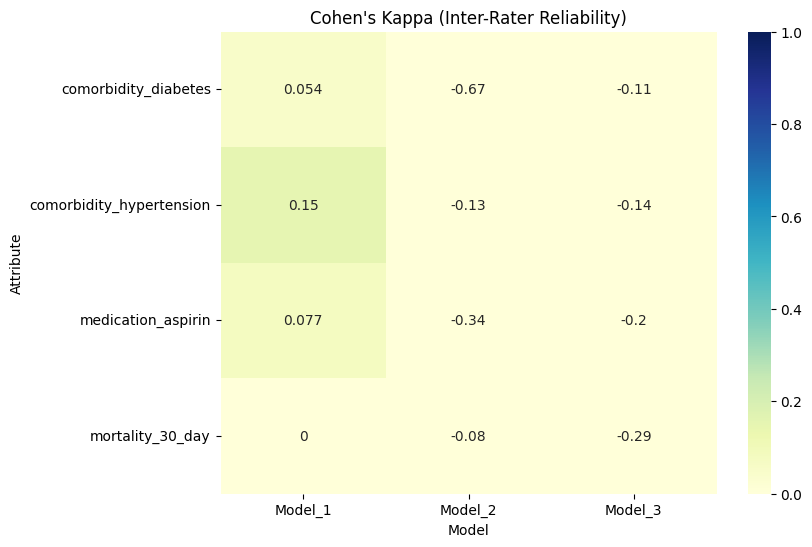

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_kappa_heatmap(kappa_df):
    heatmap_data = kappa_df.pivot(index='Attribute', columns='Model', values="Cohen's Kappa")
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
    plt.title("Cohen's Kappa (Inter-Rater Reliability)")
    plt.show()

# Example usage:
plot_kappa_heatmap(kappa_summary)
